# ===========The Battle Of Neighborhoods============

### 1. Introduction
Objective
The objective of this project is to find the best neighbourhood in Toronto to open a Italian restaurant using Foursquare location data. In this project we’ll go through the solution for this problem for avoiding or considering low risk criteria and high success rate.

Target Audiance
Business personnel who wants to invest or open a start up company or restaurant.
Bachelors who want to stay in a good city where they can get each facilities what they want like GYM,Playground,Parlour,Movie theatre etc.
The freelancer who loves to have their own small company or restaurant as a side business.
Marketing companies who want to release a new product on a best place.
Researchers who want to create a camp for Survey.
Torrists who wants to eat italian food.
Data Description
For this project we need these following data:

Toronto City data that contains Borough, Neighborhoods along with there latitudes and longitudes
Data Source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
Description: This Wikipedia page contain all the information we need to explore and cluster the neighborhoods in Toronto. We will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe so that it is in a structured format like the Toronto dataset.
Geographical Location data using Geocoder Package
Data Source: https://cocl.us/Geospatial_data
Description: The second source of data provided us with the Geographical coordinates of the neighbourhoods with the respective Postal Codes.
Venue Data using Foursquare API
Data Source: https://foursquare.com/developers/apps
Description: From Foursquare API we can get the name,category,latitude,longitude for each venue.
In this capstone project we are going to answer of these following major steps:

Assignment-1: Scrape the data from the wikipedia page of Toronto.

Assignment-2: Get the geographical coordinates of the neighborhoods using the Geocoder package.

Assignment-3: Explore and cluster the neighborhoods in Toronto.

### 2. Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 3. Scrape Neighborhoods Data

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
      # Create three columns named as "PostalCode","Borough" & "Neighborhood"
        cell['PostalCode'] = row.p.text[:3] # store only first three letter from the test of <p> tab.(Ex: M3A )
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        # here we replace some symbols like "(" , ")" , "/" from the neighborhood name(Ex: (Parkview Hill / Woodbine Gardens))
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
# compress some big borough name by smaller one
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

This is the created dataset that we'r going to use. This dataset have 3 columns i.e "PostalCode", "Borough", "Neighborhood". As the dataset is unstructured and dirty we need some data pre-processing to clean the dataset.

In [5]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

### 4. Data Pre-processing
In this step we'll do thses following steps

Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [6]:
# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [7]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [8]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [9]:
# shape of dataframe
df.shape

(103, 3)

Now data is cleaned and all the requirements are met. So we just have to add the Latitude and Longitudes of each location.

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [10]:
# get the latitude and the longitude coordinates of each Postal code
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

Now we will merge the geographical dataframe with neighborhood dataframe according to the Postal Code

In [13]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [14]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

### 4.1. Now we will visualize all the borough present in Toronto

In [15]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [16]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [17]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165047


In [18]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [20]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

### 4.2. Next we will define foursquare Credentials

In [21]:
CLIENT_ID = 'O4ACBUTHNEGXN4BPIOELIEKG0GCXOL0ZKNQZZDBOD3BQBHUD' # your Foursquare ID
CLIENT_SECRET = 'GBGG1PHT4ITZJRXCDDPCVU0WD4AHCS10XB0D54ZJQHU3NWOX' # your Foursquare Secret
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


### 4.3. Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.
First, let's create the GET request URL

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [24]:
toronto_venues.tail()

Neighborhood  \
2136  Mimico NW, The Queensway West, South of Bloor,...   
2137  Mimico NW, The Queensway West, South of Bloor,...   
2138  Mimico NW, The Queensway West, South of Bloor,...   
2139  Mimico NW, The Queensway West, South of Bloor,...   
2140  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
2136              43.628841              -79.520999   
2137              43.628841              -79.520999   
2138              43.628841              -79.520999   
2139              43.628841              -79.520999   
2140              43.628841              -79.520999   

                                      Venue  Venue Latitude  Venue Longitude  \
2136                Jim & Maria's No Frills       43.631152       -79.518617   
2137             Royal Canadian Legion #210       43.628855       -79.518903   
2138            Islington Florist & Nursery       43.630156       -79.518718   
2139  Koala Tan Tanning Salon & Sunless Spa       43.631370       -79.519006   
2140                   Kingsway Boxing Club       43.627254       -79.526684   

     Venue Category  
2136  Grocery Store  
2137    Social Club  
2138    Flower Shop  
2139  Tanning Salon  
2140            Gym

Lets check how many venues are there per neighborhood

In [25]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agincourt                                                               3   
Alderwood, Long Branch                                                  7   
Bathurst Manor, Wilson Heights, Downsview North                        22   
Bayview Village                                                         4   
Bedford Park, Lawrence Manor East                                      23   
Berczy Park                                                            57   
Birch Cliff, Cliffside West                                             4   
Brockton, Parkdale Village, Exhibition Place                           27   
CN Tower, King and Spadina, Railway Lands, Harb...                     17   
Caledonia-Fairbanks                                                     4   
Cedarbrae                                                               8   
Central Bay Street                                                     68   
Christie                                                               16   
Church and Wellesley                                                   78   
Clairville, Humberwood, Woodbine Downs, West Hu...                      4   
Clarks Corners, Tam O'Shanter, Sullivan                                13   
Cliffside, Cliffcrest, Scarborough Village West                         2   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             35   
Davisville North                                                       10   
Del Ray, Mount Dennis, Keelsdale and Silverthorn                        4   
Don Mills North                                                         5   
Don Mills South                                                        20   
Dorset Park, Wexford Heights, Scarborough Town ...                      5   
Downsview Central                                                       4   
Downsview East                                                          3   
Downsview Northwest                                                     5   
Downsview West                                                          5   
Dufferin, Dovercourt Village                                           17   
Enclave of L4W                                                         13   
Enclave of M4L                                                         15   
Enclave of M5E                                                         98   
Eringate, Bloordale Gardens, Old Burnhamthorpe,...                      7   
Fairview, Henry Farm, Oriole                                           66   
First Canadian Place, Underground city                                100   
Forest Hill North & West                                                4   
Garden District, Ryerson                                              100   
Glencairn                                                               6   
Golden Mile, Clairlea, Oakridge                                         8   
Guildwood, Morningside, West Hill                                       9   
Harbourfront East, Union Station, Toronto Islands                     100   
High Park, The Junction South                                          24   
Hillcrest Village                                                       5   
Humber Summit                                                           3   
Humberlea, Emery                                                        2   
Humewood-Cedarvale                                                      4   
India Bazaar, The Beaches West                                         20   
Kennedy Park, Ionview, East Birchmount Park                             4   
Kensington Market, Chinatown, Grange Park                              64   
Kingsview Village, St. Phillips, Martin Grove G...                      4   
Lawrence Manor, Lawrence Heights                

### 4.4. How many unique venues are there in all neighborhood ?

In [26]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques vanue categories.


In [27]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'French Restaurant' 'Intersection'
 'Pizza Place' 'Bakery' 'Distribution Center' 'Restaurant' 'Spa'
 'Gym / Fitness Center' 'Pub' 'Breakfast Spot' 'Historic Site'
 'Chocolate Shop' 'Farmers Market' 'Performing Arts Venue' 'Dessert Shop'
 'Mexican Restaurant' 'Theater' 'Yoga Studio' 'Shoe Store' 'Event Space'
 'Café' 'Asian Restaurant' 'Electronics Store' 'Art Gallery' 'Bank'
 'Beer Store' 'Health Food Store' 'Wine Shop' 'Sushi Restaurant'
 'Antique Shop' 'Boutique' 'Furniture / Home Store'
 'Vietnamese Restaurant' 'Clothing Store' 'Accessories Store'
 'Carpet Store' 'Gift Shop' 'Athletics & Sports' 'Italian Restaurant'
 'Beer Bar' 'Creperie' 'Burrito Place' 'Fried Chicken Joint' 'Hobby Shop'
 'Diner' 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'College Cafeteria' 'Music Venue'
 'Caribbean Restaurant' 'Gastropub' '

### 4.5. Are there any Italian Restaurants present in the venues?

In [28]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

True

### 5. Data Analysis
5.1. Now we will analyze each neighborhood
As the column "Venue Category" contain categorical value.So we need to convert it to numerical values by one hot encoding.

In [29]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2141, 272)


Neighborhoods  Accessories Store  Airport  Airport Food Court  \
0         Parkwoods                  0        0                   0   
1         Parkwoods                  0        0                   0   
2         Parkwoods                  0        0                   0   
3  Victoria Village                  0        0                   0   
4  Victoria Village                  0        0                   0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0             0               0                0                 0   
1             0               0                0                 0   
2             0               0                0                 0   
3             0               0                0                 0   
4             0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Workshop  \
0                    0                 0                   0              0   
1                    0                 0                   0              0   
2                    0                 0                   0              0   
3                    0                 0                   0              0   
4                    0                 0                   0              0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          0           0           0       0     0    0               0   
1          0           0           0       0     0    0               0   
2          0           0           0       0     0    0               0   
3          0           0           0       0     0    0               0   
4          0           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0                 0                 0                   0      0   
1                 0                 0                   0      0   
2                 0                 0                   0      0   
3                 0                 0                   0      0   
4                 0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0       0              0          0         0                     0   
1       0              0          0         0                     0   
2       0              0          0         0                     0   
3       0              0          0         0                     0   
4       0              0          0         0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0               0        0            0                0         0   
1               0        0            0                0         0   
2               0        0            0                0         0   
3               0        0            0                0         0   
4               0        0            0                0         0   

   Burger Joint  Burrito Place  Bus Line  Bus Station  Business Service  

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [30]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(99, 272)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Airport  Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0      0.0                 0.0           0.0             0.0              0.0   
1      0.0                 0.0           0.0             0.0              0.0   
2      0.0                 0.0           0.0             0.0              0.0   
3      0.0                 0.0           0.0             0.0              0.0   
4      0.0                 0.0           0.0             0.0              0.0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0               0.0             0.000000           0.0       0.0          0.0   
1               0.0             0.000000           0.0       0.0          0.0   
2               0.0             0.000000           0.0       0.0          0.0   
3               0.0             0.000000           0.0       0.0          0.0   
4               0.0             0.043478           0.0       0.0          0.0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.0                  0.0               0.0                 0.0   
1         0.0                  0.0               0.0                 0.0   
2         0.0                  0.0               0.0                 0.0   
3         0.0                  0.0               0.0                 0.0   
4         0.0                  0.0               0.0                 0.0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  \
0            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   
1            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   
2            0.0        0.0         0.0         0.0     0.0  0.090909  0.0   
3            0.0        0.0         0.0         0.0     0.0  0.250000  0.0   
4            0.0        0.0         0.0         0.0     0.0  0.000000  0.0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0             0.0               0.0               0.0                 0.0   
1             0.0               0.0               0.0                 0.0   
2             0.0               0.0               0.0                 0.0   
3             0.0               0.0               0.0                 0.0   
4             0.0               0.0               0.0                 0.0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0    0.0              0.0       0.0         0.0                 0.0   
1    0.0              0.0       0.0         0.0                 0.0   
2    0.0              0.0       0.0         0.0                 0.0   
3    0.0              0.0       0.0         0.0                 0.0   
4    0.0              0.0       0.0         0.0                 0.0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0        0.0     0.0            0.0        0.0       0.0   
1        0.0     0.0            0.0        0.0       0.0   
2        0.0     0.0            0.0        0.0       0.0   
3        0.0     0.0            0.0        0.0       0.0   
4        0.0     0.0            0.0        0.0       0.0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                   0.0        0.333333      0.0     0.000000   
1                   0.0        0.000000      0.0     0.000000   
2                   0.0        0.000000      0.0     0.045455   
3                   0.0        0.000000      0.0     0.000000   
4                   0.0        0.000000      0.0     0.000000   

   Bubble Tea Shop  Building  Burger Joint  Burrito Plac

Here we only require the "Neighborhoods" and "Italian Restaurant" columns for the clustering. So we'll group these two columns.

In [31]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

Neighborhoods  Italian Restaurant
0                                        Agincourt            0.000000
1                           Alderwood, Long Branch            0.000000
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000
3                                  Bayview Village            0.000000
4                Bedford Park, Lawrence Manor East            0.086957

In [32]:
# rename column "Neighborhoods" to "Neighborhood"
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

### 6. Clustering
We will use k-means clustering. But first we will find the best K value using the Elbow Point method.

6.1. Elbow Method

In [33]:
# drop "Neighborhood" column from the dataframe
X = ita.drop(['Neighborhood'], axis=1)

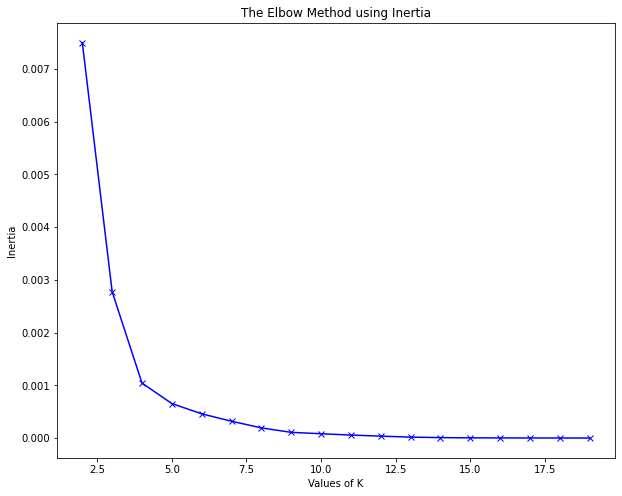

In [34]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Here,We saw that the optimum K value is 4 so we will have a resulting of 4 clusters.

In [35]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 2, 0, 3, 0, 0])

In [36]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2, 3])

Now create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [37]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [38]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

In [39]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2141, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
0               Agincourt                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   
1  Alderwood, Long Branch                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.794200              -79.262029   
0              43.794200              -79.262029   
0              43.794200              -79.262029   
1              43.602414              -79.543484   
1              43.602414              -79.543484   

                              Venue  Venue Latitude  Venue Longitude  \
0       Panagio's Breakfast & Lunch       43.792370       -79.260203   
0                          Twilight       43.791999       -79.258584   
0                     El Pulgarcito       43.792648       -79.259208   
1  Il Paesano Pizzeria & Restaurant       43.601280       -79.545028   
1  Toronto Gymnastics International       43.599832       -79.542924   

              Venue Category  
0             Breakfast Spot  
0                     Lounge  
0  Latin American Restaurant  
1                Pizza Place  
1                        Gym

In [40]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2141, 9)


Neighborhood  Italian Restaurant  Cluster Labels  \
31      Enclave of M5E            0.040816               3   
31      Enclave of M5E            0.040816               3   
31      Enclave of M5E            0.040816               3   
31      Enclave of M5E            0.040816               3   
11  Central Bay Street            0.044118               3   

    Neighborhood Latitude  Neighborhood Longitude                     Venue  \
31              43.646435              -79.374846                  Crepe TO   
31              43.646435              -79.374846                 CC Lounge   
31              43.646435              -79.374846              Crepe It Up!   
31              43.646435              -79.374846  Ki Modern Japanese + Bar   
11              43.657952              -79.387383        The Yoga Sanctuary   

    Venue Latitude  Venue Longitude       Venue Category  
31       43.650063       -79.374587             Creperie  
31       43.647917       -79.374520         Cocktail Bar  
31       43.648736       -79.371623             Creperie  
31       43.647223       -79.379374  Japanese Restaurant  
11       43.661499       -79.383636          Yoga Studio

Lets check how many Italian Restaurant are there

In [41]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

40

We see that there are a total of 46 locations with Italian Restaurants in Toronto.
We will create a new dataframe with the Neighborhood and Italian Restaurants

6.2. Visualize Clustering on Google Map

In [42]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

6.2. How many Neighborhoods per Cluster?

In [43]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt            0.000000   
1                           Alderwood, Long Branch            0.000000   
2  Bathurst Manor, Wilson Heights, Downsview North            0.000000   
3                                  Bayview Village            0.000000   
4                Bedford Park, Lawrence Manor East            0.086957   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

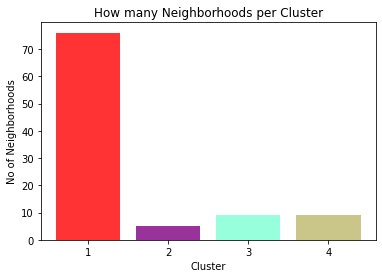

In [44]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [45]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    76
2     9
3     9
1     5
Name: Cluster Labels, dtype: int64

6.3. Analysis of each Cluster

#### Cluster 1

In [46]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [47]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York         Parkwoods                 0.0               0   
1  North York         Parkwoods                 0.0               0   
2  North York         Parkwoods                 0.0               0   
3  North York  Victoria Village                 0.0               0   
4  North York  Victoria Village                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude                   Venue  \
0              43.753259              -79.329656           Variety Store   
1              43.753259              -79.329656                     KFC   
2              43.753259              -79.329656         Brookbanks Park   
3              43.725882              -79.315572  Victoria Village Arena   
4              43.725882              -79.315572             Tim Hortons   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.751974       -79.333114     Food & Drink Shop  
1       43.754387       -79.333021  Fast Food Restaurant  
2       43.751976       -79.332140                  Park  
3       43.723481       -79.315635          Hockey Arena  
4       43.725517       -79.313103           Coffee Shop

#### Cluster 2

In [48]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough Neighborhood  Italian Restaurant  Cluster Labels  \
0  Downtown Toronto     Christie              0.0625               1   
1  Downtown Toronto     Christie              0.0625               1   
2  Downtown Toronto     Christie              0.0625               1   
3  Downtown Toronto     Christie              0.0625               1   
4  Downtown Toronto     Christie              0.0625               1   

   Neighborhood Latitude  Neighborhood Longitude                Venue  \
0              43.669542              -79.422564  Garrison Creek Park   
1              43.669542              -79.422564        Sobeys Dupont   
2              43.669542              -79.422564              Loblaws   
3              43.669542              -79.422564    Stubbe Chocolates   
4              43.669542              -79.422564          Faema Caffe   

   Venue Latitude  Venue Longitude Venue Category  
0       43.671690       -79.427805           Park  
1       43.670977       -79.427573  Grocery Store  
2       43.671657       -79.421364  Grocery Store  
3       43.671566       -79.421289    Candy Store  
4       43.671046       -79.419297           Café

#### Cluster 3

In [49]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough                   Neighborhood  Italian Restaurant  \
0  Queen's Park  Ontario Provincial Government            0.029412   
1  Queen's Park  Ontario Provincial Government            0.029412   
2  Queen's Park  Ontario Provincial Government            0.029412   
3  Queen's Park  Ontario Provincial Government            0.029412   
4  Queen's Park  Ontario Provincial Government            0.029412   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               2              43.662301              -79.389494   
1               2              43.662301              -79.389494   
2               2              43.662301              -79.389494   
3               2              43.662301              -79.389494   
4               2              43.662301              -79.389494   

                    Venue  Venue Latitude  Venue Longitude  \
0       Bubble Bath & Spa       43.659050       -79.385344   
1      Hart House Theatre       43.663571       -79.394616   
2  Coach House Restaurant       43.664991       -79.384814   
3            Sushi Garden       43.664858       -79.384941   
4             Tokyo Grill       43.665085       -79.384707   

        Venue Category  
0                  Spa  
1              Theater  
2                Diner  
3     Sushi Restaurant  
4  Japanese Restaurant

#### Cluster 4

In [50]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough     Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York  Don Mills South                0.05               3   
1  North York  Don Mills South                0.05               3   
2  North York  Don Mills South                0.05               3   
3  North York  Don Mills South                0.05               3   
4  North York  Don Mills South                0.05               3   

   Neighborhood Latitude  Neighborhood Longitude             Venue  \
0                43.7259              -79.340923   C&C Supermarket   
1                43.7259              -79.340923            Oomomo   
2                43.7259              -79.340923    Anthony's Cafe   
3                43.7259              -79.340923     Delimark Cafe   
4                43.7259              -79.340923  Congee Star 帝王名粥   

   Venue Latitude  Venue Longitude      Venue Category  
0       43.725556       -79.341667       Grocery Store  
1       43.726429       -79.343283      Discount Store  
2       43.723687       -79.336701                Café  
3       43.727536       -79.339547         Coffee Shop  
4       43.726586       -79.341833  Chinese Restaurant

6.4. Number of neighborhoods per cluster vs Average number of Italian Restaurants in each Cluster

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

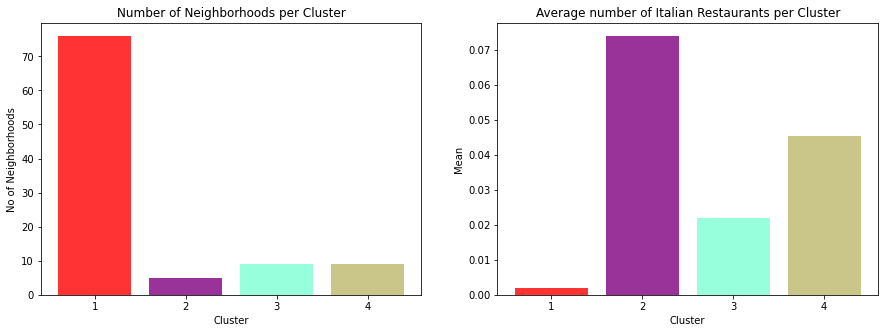

In [51]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                df_cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

## 7. Conclusion
The Neighborhoods located in the East Toronto area(cluster-3) have the highest average of Italian Restaurants which is represented by aquamarine colour. North York has second heighest number of Italian restaurants present. Looking at the nearby venues, the optimum place to put a new Italian Restaurant is in Victoria village,North York(cluster-1) as their are many Neighborhoods in that area but a little number of Italian Restaurants therefore, eliminating any competition.The second best Neighborhoods that have a great oppurtunity would be in areas such as Queen's Park which is in Cluster 4.Having 70 neighborhoods in the area with no Italian Restaurants gives a good oppurtunity for opening up a new restaurant. This concludes the optimal findings for this project and recommends the entrepreneur to open an authentic Italian restaurant in these locations with little to no competition. Nonetheless, if the food is authentic, affordable and good taste, I am confident that it will have great following everywhere.

Here we take an Italian Restaurant as an example. We can do the same process to find the best place or neighborhood

to open a start up company
to stay on rent for bachelors
to start a side business for middle class people
to open a camp for any kind of servey
to release a new product for checking the success rate

## 8. Future Work
Apply different types of clustering algorithms to cluster the neighborhoods.
Consider other food vanues,market area etc. as features for clustering.
Consider more then 100 vanues in a neighborhood for analysis using Foursquare api.